In [25]:
## Initialize Hyperparameters and import libraries

import numpy as np
import torch

import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
from timeit import default_timer

import operator
from functools import reduce
from functools import partial

In [26]:
## Import Data

n_train = 20000
n_test = 100
n_total = n_test+n_train

test_structs = np.empty((n_test, 1, 225, 64), np.float32)
test_results = np.empty((n_test, 1, 31, 225, 64),  np.float32)

for i in range (n_test):

    tmp_struct = np.load("C:\\Users\\user\\neuraloperator\\1D Color Router\\SANZABOO\\patternings\\patterning_"+f'{i+n_train:08d}'+".npy")
    tmp_result = np.load("C:\\Users\\user\\neuraloperator\\1D Color Router\\SANZABOO\\true_results\\result_Sz_"+f'{i+n_train:08d}'+".npy")

    sampled_result = -1*tmp_result

    test_structs[i][0][:15] = np.ones((1*15,64))
    test_structs[i][0][15:75] = np.repeat(np.repeat(tmp_struct, 15, axis=0), 2, axis=1)
    test_structs[i][0][75:] = np.ones((10*15,64))*2
    test_results[i][0] = sampled_result

    if i%500 ==0 :
        print(i)


0


In [27]:
# Define 2D FNO Model

#Complex multiplication
def compl_mul2d(a, b):
    # (batch, in_channel, x,y ), (in_channel, out_channel, x,y) -> (batch, out_channel, x,y)
    op = partial(torch.einsum, "bixy,ioxy->boxy")
    return torch.stack([
        op(a[..., 0], b[..., 0]) - op(a[..., 1], b[..., 1]),
        op(a[..., 1], b[..., 0]) + op(a[..., 0], b[..., 1])
    ], dim=-1)

################################################################
# fourier layer
################################################################
class SpectralConv2d(nn.Module):
    def __init__(self, in_channels, out_channels, modes1, modes2):
        super(SpectralConv2d, self).__init__()

        """
        2D Fourier layer. It does FFT, linear transform, and Inverse FFT.    
        """

        self.in_channels = in_channels
        self.out_channels = out_channels
        self.modes1 = modes1 #Number of Fourier modes to multiply, at most floor(N/2) + 1
        self.modes2 = modes2

        self.scale = (1 / (in_channels * out_channels))
        self.weights1 = nn.Parameter(self.scale * torch.rand(in_channels, out_channels, self.modes1, self.modes2, dtype=torch.cfloat))
        self.weights2 = nn.Parameter(self.scale * torch.rand(in_channels, out_channels, self.modes1, self.modes2, dtype=torch.cfloat))

    # Complex multiplication
    def compl_mul2d(self, input, weights):
        # (batch, in_channel, x,y ), (in_channel, out_channel, x,y) -> (batch, out_channel, x,y)
        return torch.einsum("bixy,ioxy->boxy", input, weights)

    def forward(self, x):
        batchsize = x.shape[0]
        #Compute Fourier coeffcients up to factor of e^(- something constant)
        x_ft = torch.fft.rfft2(x)

        # Multiply relevant Fourier modes
        out_ft = torch.zeros(batchsize, self.out_channels,  x.size(-2), x.size(-1)//2 + 1, dtype=torch.cfloat, device=x.device)
        out_ft[:, :, :self.modes1, :self.modes2] = \
            self.compl_mul2d(x_ft[:, :, :self.modes1, :self.modes2], self.weights1)
        out_ft[:, :, -self.modes1:, :self.modes2] = \
            self.compl_mul2d(x_ft[:, :, -self.modes1:, :self.modes2], self.weights2)

        #Return to physical space
        x = torch.fft.irfft2(out_ft, s=(x.size(-2), x.size(-1)))
        return x.to(torch.float32)


class FNO2d_struct(nn.Module):
    def __init__(self, modes_x, modes_y, width, FNO_layer_num, FC_neuron):
        super(FNO2d_struct, self).__init__()

        """
        The overall network. It contains 4 layers of the Fourier layer.
        1. Lift the input to the desire channel dimension by self.fc0 .
        2. 4 layers of the integral operators u' = (W + K)(u).
            W defined by self.w; K defined by self.conv .
        3. Project from the channel space to the output space by self.fc1 and self.fc2 .
        
        input: the solution of the coefficient function and locations (a(x, y))
        input shape: (batchsize, x=s, y=s, c=1)
        output: the solution 
        output shape: (batchsize, c=1)
        """

        # default value 정의
        self.modes_x = modes_x
        self.modes_y = modes_y
        self.width = width
        self.FNO_layer_num = FNO_layer_num
        self.FC_neuron = FC_neuron
        
        self.conv_layers = nn.ModuleList([
            SpectralConv2d(self.width, self.width, self.modes_x, self.modes_y) for _ in range(self.FNO_layer_num)
        ])

        self.w_layers = nn.ModuleList([
            nn.Conv2d(self.width, self.width, 1) for _ in range(self.FNO_layer_num)
        ])
        # FNO의 figure2에서 Q에 해당하는 값.
        self.fc0 = nn.Linear(1, self.width)

        self.fc1_ori = nn.Linear(self.width, self.FC_neuron)
        self.fc2_ori = nn.Linear(self.FC_neuron, 31)


    def forward(self, x):

        x = x.permute(0, 2, 3, 1)
        x = self.fc0(x)
        x = F.gelu(x)
        #x = torch.sin(x)
        x = x.permute(0, 3, 1, 2) # Batch size, channels

        for i in range(self.FNO_layer_num-1):
            x1 = self.conv_layers[i](x)
            x2 = self.w_layers[i](x)
            x = x1 + x2 # + input
            x = F.gelu(x)
            #x = torch.sin(x)

        x1 = self.conv_layers[i](x)
        x2 = self.w_layers[i](x)
        x = x1 + x2

        x = x.permute(0, 2, 3, 1)
        x = self.fc1_ori(x)
        x = F.gelu(x)
        #x = torch.sin(x)
        x = self.fc2_ori(x)

        x = x.permute(0, 3, 1, 2)

        return x.reshape(x.shape[0], 1, 31, x.shape[2], x.shape[3])
    
    def get_grid(self, shape, device):
        batchsize, size_x, size_y = shape[0], shape[1], shape[2]
        gridx = torch.tensor(np.linspace(0, 1, size_x), dtype=torch.float)
        gridx = gridx.reshape(1, size_x, 1, 1).repeat([batchsize, 1, size_y, 1])
        gridy = torch.tensor(np.linspace(0, 1, size_y), dtype=torch.float)
        gridy = gridy.reshape(1, 1, size_y, 1).repeat([batchsize, size_x, 1, 1])
        return torch.cat((gridx, gridy), dim=-1).to(device)
    
    def count_params(self):
        c = 0
        for p in self.parameters():
            c += reduce(operator.mul, list(p.size()))
        return c

In [28]:
def RGB(field_cell_meent_1d):

    res_x = 64

    R_index_i = 0
    R_index_f = 16
    
    G_index_i = 16
    G_index_f = 32

    B_index_i = 32
    B_index_f = 48

    I_index_i = 48
    I_index_f = 64
    
    B = torch.sum(field_cell_meent_1d[B_index_i:B_index_f])/(0.5*res_x)
    G1 = torch.sum(field_cell_meent_1d[G_index_i:G_index_f])/(0.5*res_x)
    R = torch.sum(field_cell_meent_1d[R_index_i:R_index_f])/(0.5*res_x)
    G2 = torch.sum(field_cell_meent_1d[I_index_i:I_index_f])/(0.5*res_x)

    G = G1 + G2

    return 4*R, 2*G, 4*B

In [29]:
model = torch.load("Sz_2D Expand_20K")

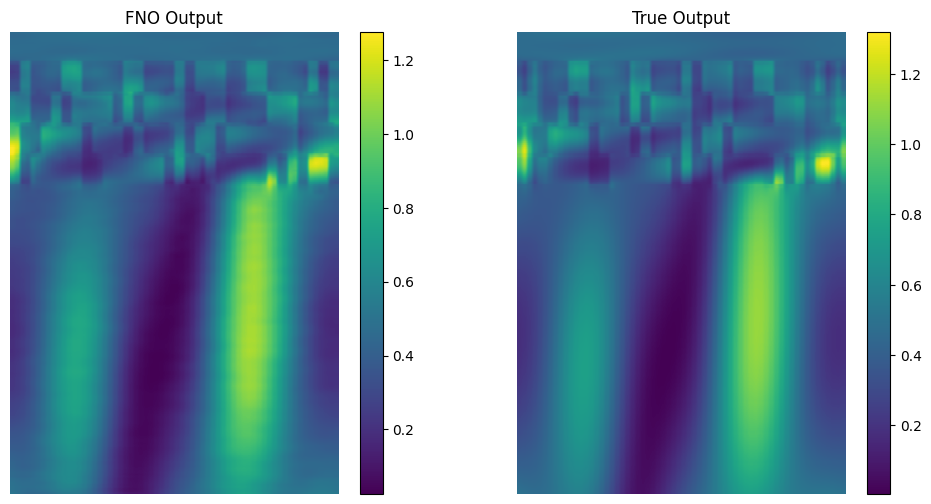

In [ ]:
n = np.random.randint(0, n_test)

# Prepare the sample input and pass it through the model
tmp_sample = torch.tensor(np.reshape(test_structs[n], (1, 1, 225, -1)))
sample_result = model(tmp_sample.cuda()).cpu().detach().numpy()
sample_result = np.squeeze(sample_result)

# Create subplots for side-by-side comparison
fig, axes = plt.subplots(1, 2, figsize=(12, 6))  # 1 row, 2 columns, adjust figure size as needed

# Left plot: FNO output
im1 = axes[0].imshow(sample_result[30], aspect = 0.4)
axes[0].set_title("FNO Output")
fig.colorbar(im1, ax=axes[0])
axes[0].axis('off')

# Right plot: True output
im2 = axes[1].imshow(test_results[n][0][30], aspect = 0.4)
axes[1].set_title("True Output")
fig.colorbar(im2, ax=axes[1])
axes[1].axis('off')

# Display the plot
plt.show()

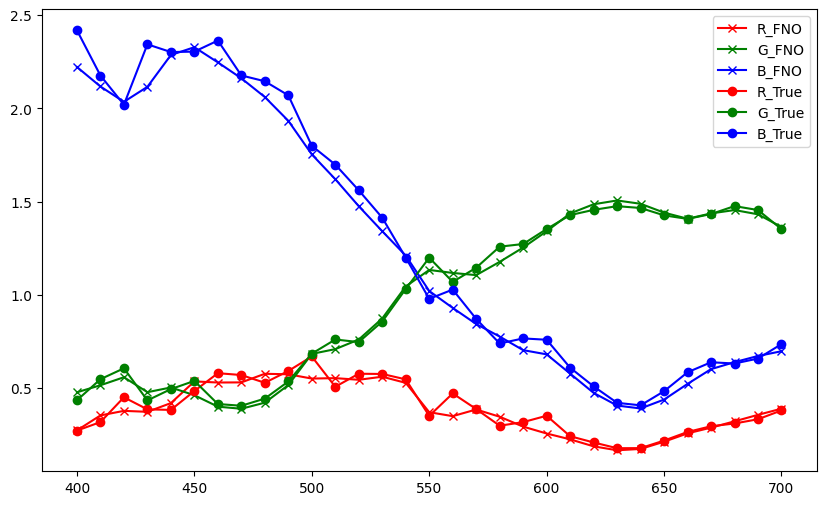

0.03987545864556425


In [60]:
n = np.random.randint(0, n_test)
tmp_sample = torch.tensor(np.reshape(test_structs[n], (1, 1, 225, -1)))
sample_result = model(tmp_sample.cuda()).cpu().detach().numpy()
sample_result = np.squeeze(sample_result)

FNO_response = []
True_response = []
for i in range(np.shape(test_results)[2]):
    tmp = RGB(torch.tensor(sample_result[i][-1]))
    FNO_response.append([tmp[0].numpy(), tmp[1].numpy(), tmp[2].numpy()])

for i in range(np.shape(test_results)[2]):
    tmp = RGB(torch.tensor(test_results[n][0][i][-1]))
    True_response.append([tmp[0].numpy(), tmp[1].numpy(), tmp[2].numpy()])

wav_len_step = 10
wav_len_list = [400 + i * wav_len_step for i in range((300) // wav_len_step + 1)]

FNO_response = np.array(FNO_response)
True_response = np.array(True_response)

plt.figure(figsize=(10, 6))

plt.plot(wav_len_list, FNO_response[:,0], label="R_FNO", color="r", marker="x")
plt.plot(wav_len_list, FNO_response[:,1], label="G_FNO", color="g", marker="x")
plt.plot(wav_len_list, FNO_response[:,2], label="B_FNO", color="b", marker="x")

plt.plot(wav_len_list, True_response[:,0], label="R_True", color="r", marker="o")
plt.plot(wav_len_list, True_response[:,1], label="G_True", color="g", marker="o")
plt.plot(wav_len_list, True_response[:,2], label="B_True", color="b", marker="o")

plt.legend()
plt.show()

print(np.sum(np.abs(FNO_response-True_response))/93)

In [33]:
RGB_abs_err = []

for n in range (n_test):

    # Prepare the sample input and pass it through the model
    tmp_sample = torch.tensor(np.reshape(test_structs[n], (1, 1, 225, -1)))
    sample_result = model(tmp_sample.cuda()).cpu().detach().numpy()
    sample_result = np.squeeze(sample_result)

    FNO_response = []
    True_response = []

    for i in range(np.shape(test_results)[2]):
        tmp = RGB(torch.tensor(sample_result[i][-1]))
        FNO_response.append([tmp[0].numpy(), tmp[1].numpy(), tmp[2].numpy()])
        tmp = RGB(torch.tensor(test_results[n][0][i][-1]))
        True_response.append([tmp[0].numpy(), tmp[1].numpy(), tmp[2].numpy()])
    FNO_response = np.array(FNO_response)
    True_response = np.array(True_response)

    RGB_abs_err.append(np.sum(np.abs(FNO_response-True_response))/93)
        

In [37]:
RGB_abs_err = np.array(RGB_abs_err)
print("Mean absolute error for",n_test,"samples: ", np.average(RGB_abs_err))
print("Standard deviation: ", np.std(RGB_abs_err))

Mean absolute error for 100 samples:  0.03786061622763193
Standard deviation:  0.00864327274217213


In [38]:
t1 = default_timer()

for n in range (n_test):

    # Prepare the sample input and pass it through the model
    tmp_sample = torch.tensor(np.reshape(test_structs[n], (1, 1, 225, -1)))
    sample_result = model(tmp_sample.cuda()).cpu().detach().numpy()
    sample_result = np.squeeze(sample_result)

    FNO_response = []

    for i in range(np.shape(test_results)[2]):
        tmp = RGB(torch.tensor(sample_result[i][-1]))
        FNO_response.append([tmp[0].numpy(), tmp[1].numpy(), tmp[2].numpy()])

t2 = default_timer()

FNO_time = t2 - t1

print("Time to execute", n_test,"simulations via FNO: ", FNO_time)
print("Average time for one simulation: ", FNO_time/n_test)

Time to execute 100 simulations via FNO:  1.0050349999801256
Average time for one simulation:  0.010050349999801256
